In [ ]:
"""
RUL_ML_Framework
File Name: feature_gen.ipynb

Description: data cleansing and feature generation

Author: junghwan lee

Email: jhrrlee@gmail.com
Date Created: 2023.09.07

"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
import pickle
import itertools
import math
import cleansing_lib as cl
import importlib

In [ ]:
importlib.reload(cl)

In [3]:
from pathlib import Path
data_path = Path('..') / 'battery_data' / 'mit'
gen_path = Path('..') / 'resource' / 'dataset'

battery_data_path = data_path / 'bat_dict.pkl'
eol_path = gen_path / 'eol.npy'
cycle_data_dis_path = gen_path / 'cycle_data_dis.npy'
cycle_data_ch_path = gen_path / 'cycle_data_ch.npy'
new_cycle_sum_path = gen_path / 'new_cycle_sum.npy'

In [ ]:
ith open(battery_data_path, 'rb') as f:
    bat_dict = pickle.load(f)

In [ ]:
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30

In [ ]:
# {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}

This function is designed to visualize battery charge and discharge data and apply basic cleansing logic to identify accurate start and end points for the discharging phase.

Parameters:
bat_dict: A nested dictionary containing battery data. Each key represents a cell, and its value is another dictionary with cycle data and summary data.

cell_key: A string indicating the specific battery cell to be analyzed.

cycle_key: A string indicating the specific cycle of the battery cell to be analyzed.

max_gap (dQd/dt): An integer. It is the maximum allowable difference between consecutive indices in the discharge start determination logic. This helps to filter out noise or small fluctuations in the data and identify a reliable start point for the discharging phase. If the difference between indices exceeds this value, it will not be considered as a valid discharge start point.

validation_range: An integer. It defines the length of the sequence of indices being checked for consistent gaps when determining the start of the discharging phase. It's essentially the window size over which we're looking for consecutive or near-consecutive indices. A larger value means a stricter criterion, ensuring that the start point selected is consistent over a longer range.

Description:
The battery's discharging phase is identified by an increase in the Qd (discharge capacity) value. However, to ensure the identified start of the discharging phase isn't due to noise or minor fluctuations, the function applies a heuristic:

Look for points where the difference in Qd is positive (indicating a potential start of discharge).

From these points, identify sequences where the difference between consecutive indices (gaps) are all smaller than the max_gap value.

The validation_range parameter ensures that this consistent sequence of gaps is observed over a specified range, adding an extra layer of validation.
Verification both data and cleasing code

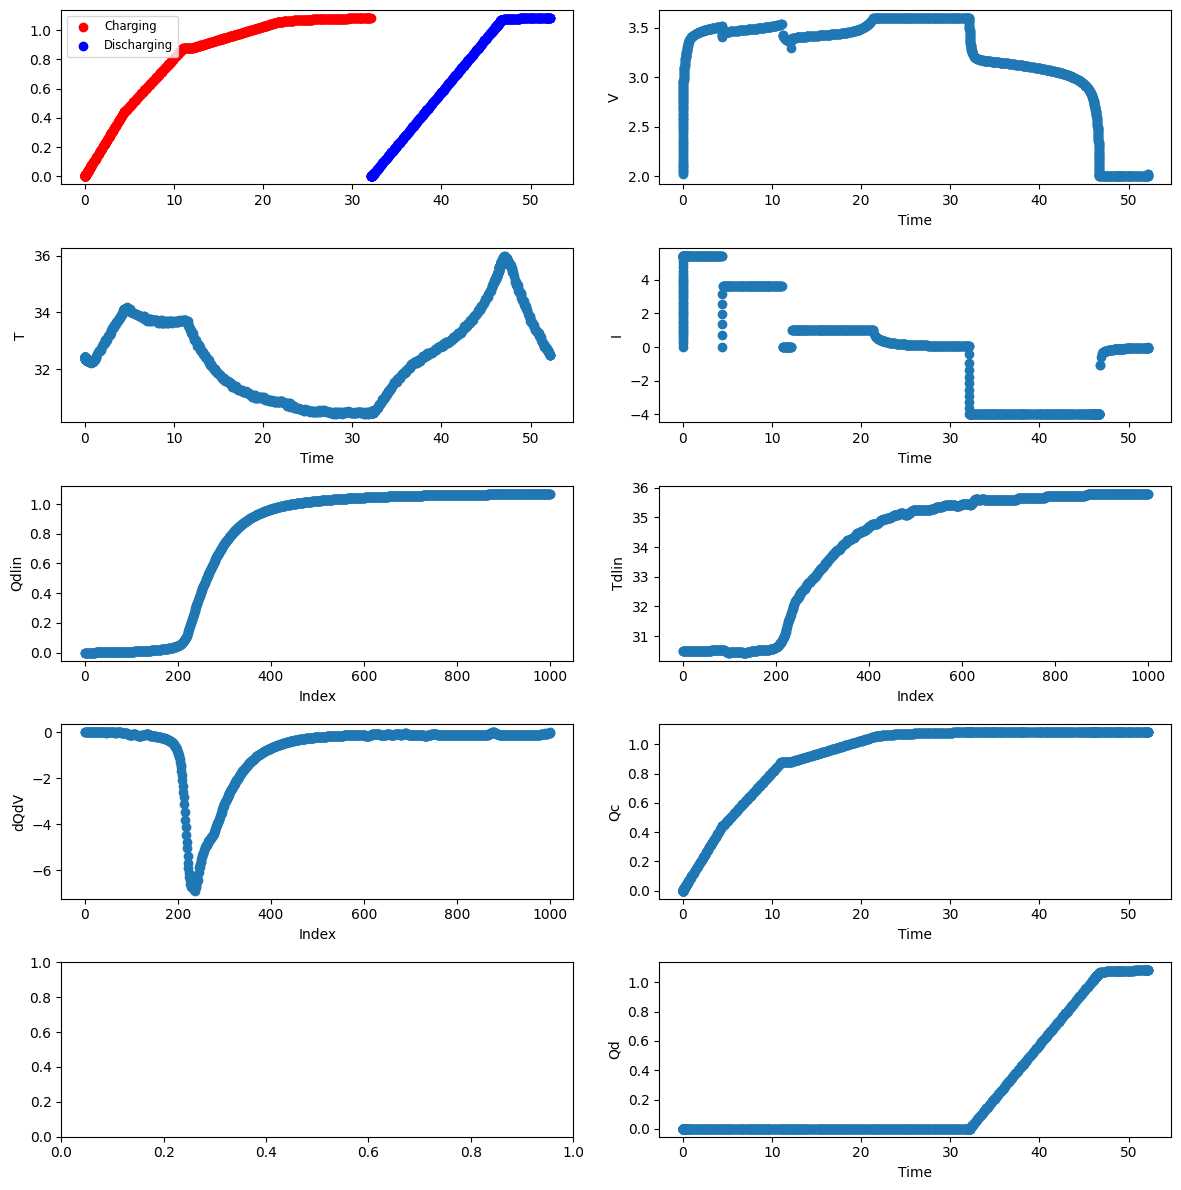

In [ ]:
cl.plot_cleansed_cycle(cl.get_cycle_data(bat_dict, 'b1c9'), '1', ch_current_threshold=0, validation_range=20, max_gap=20)

This function is more advanced for debugging of data cleasing with logs and plots. </br>
to verify multiple cycle

 89%|████████▉ | 888/1000 [00:36<00:11, 10.07it/s]

remove cycle from time 886


1001it [00:43, 23.13it/s]                          


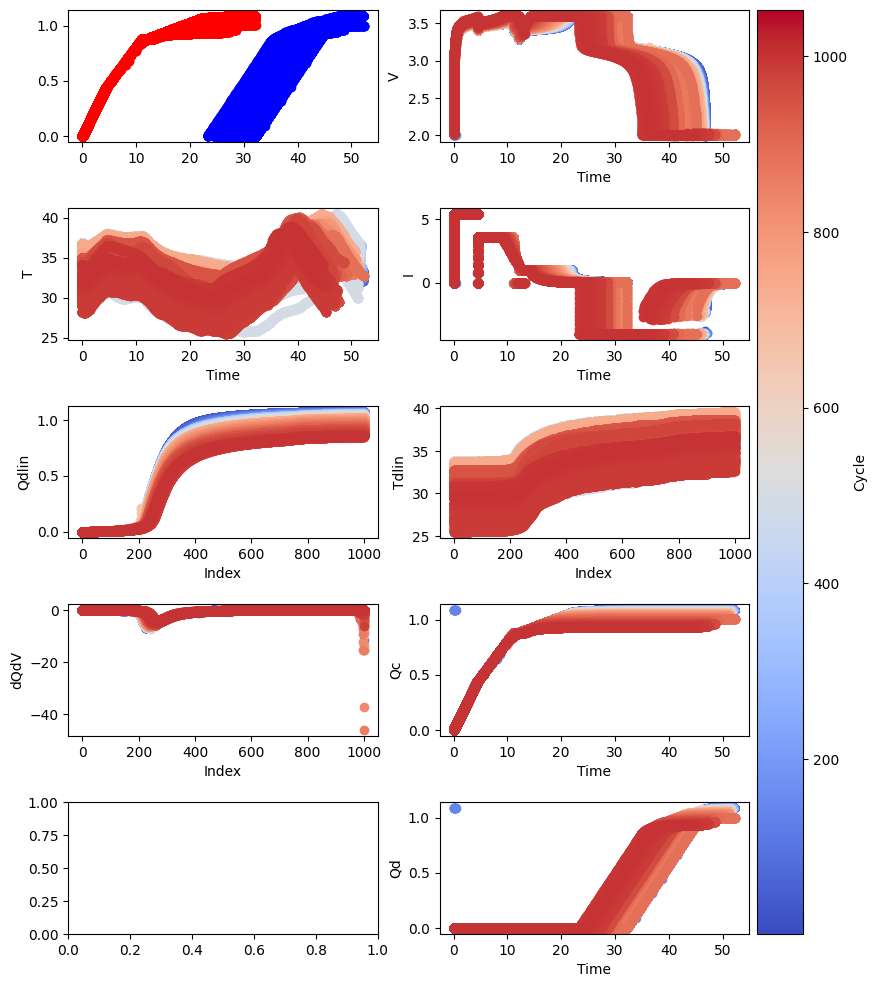

In [ ]:
cl.plot_cleansed_cycles(get_cycle_data(bat_dict, 'b1c9'), 1, 1000)

This function generates interpolated data for a complete cycle (charging, discharging cycle)

In [ ]:
no_of_features = 8
no_of_cycles = 100
max_data_size = 1000
no_of_timeseries = 1000
cycle_start = 1

eol, cleaned_cycle_data = cl.get_inp_cycles(bat_dict, cycle_start, no_of_cycles, max_data_size, no_of_timeseries)

In [ ]:
cleaned_cycle_data=np.array(cleaned_cycle_data).reshape(-1,no_of_cycles,no_of_features,no_of_timeseries) #(number of cell, first n cycle, property, time-series data)
eol=np.array(eol).reshape(-1,1)

In [ ]:
print(eol.shape, cleaned_cycle_data.shape)

(124, 1) (124, 100, 8, 1000)


Regardless of time, features are alinged with index

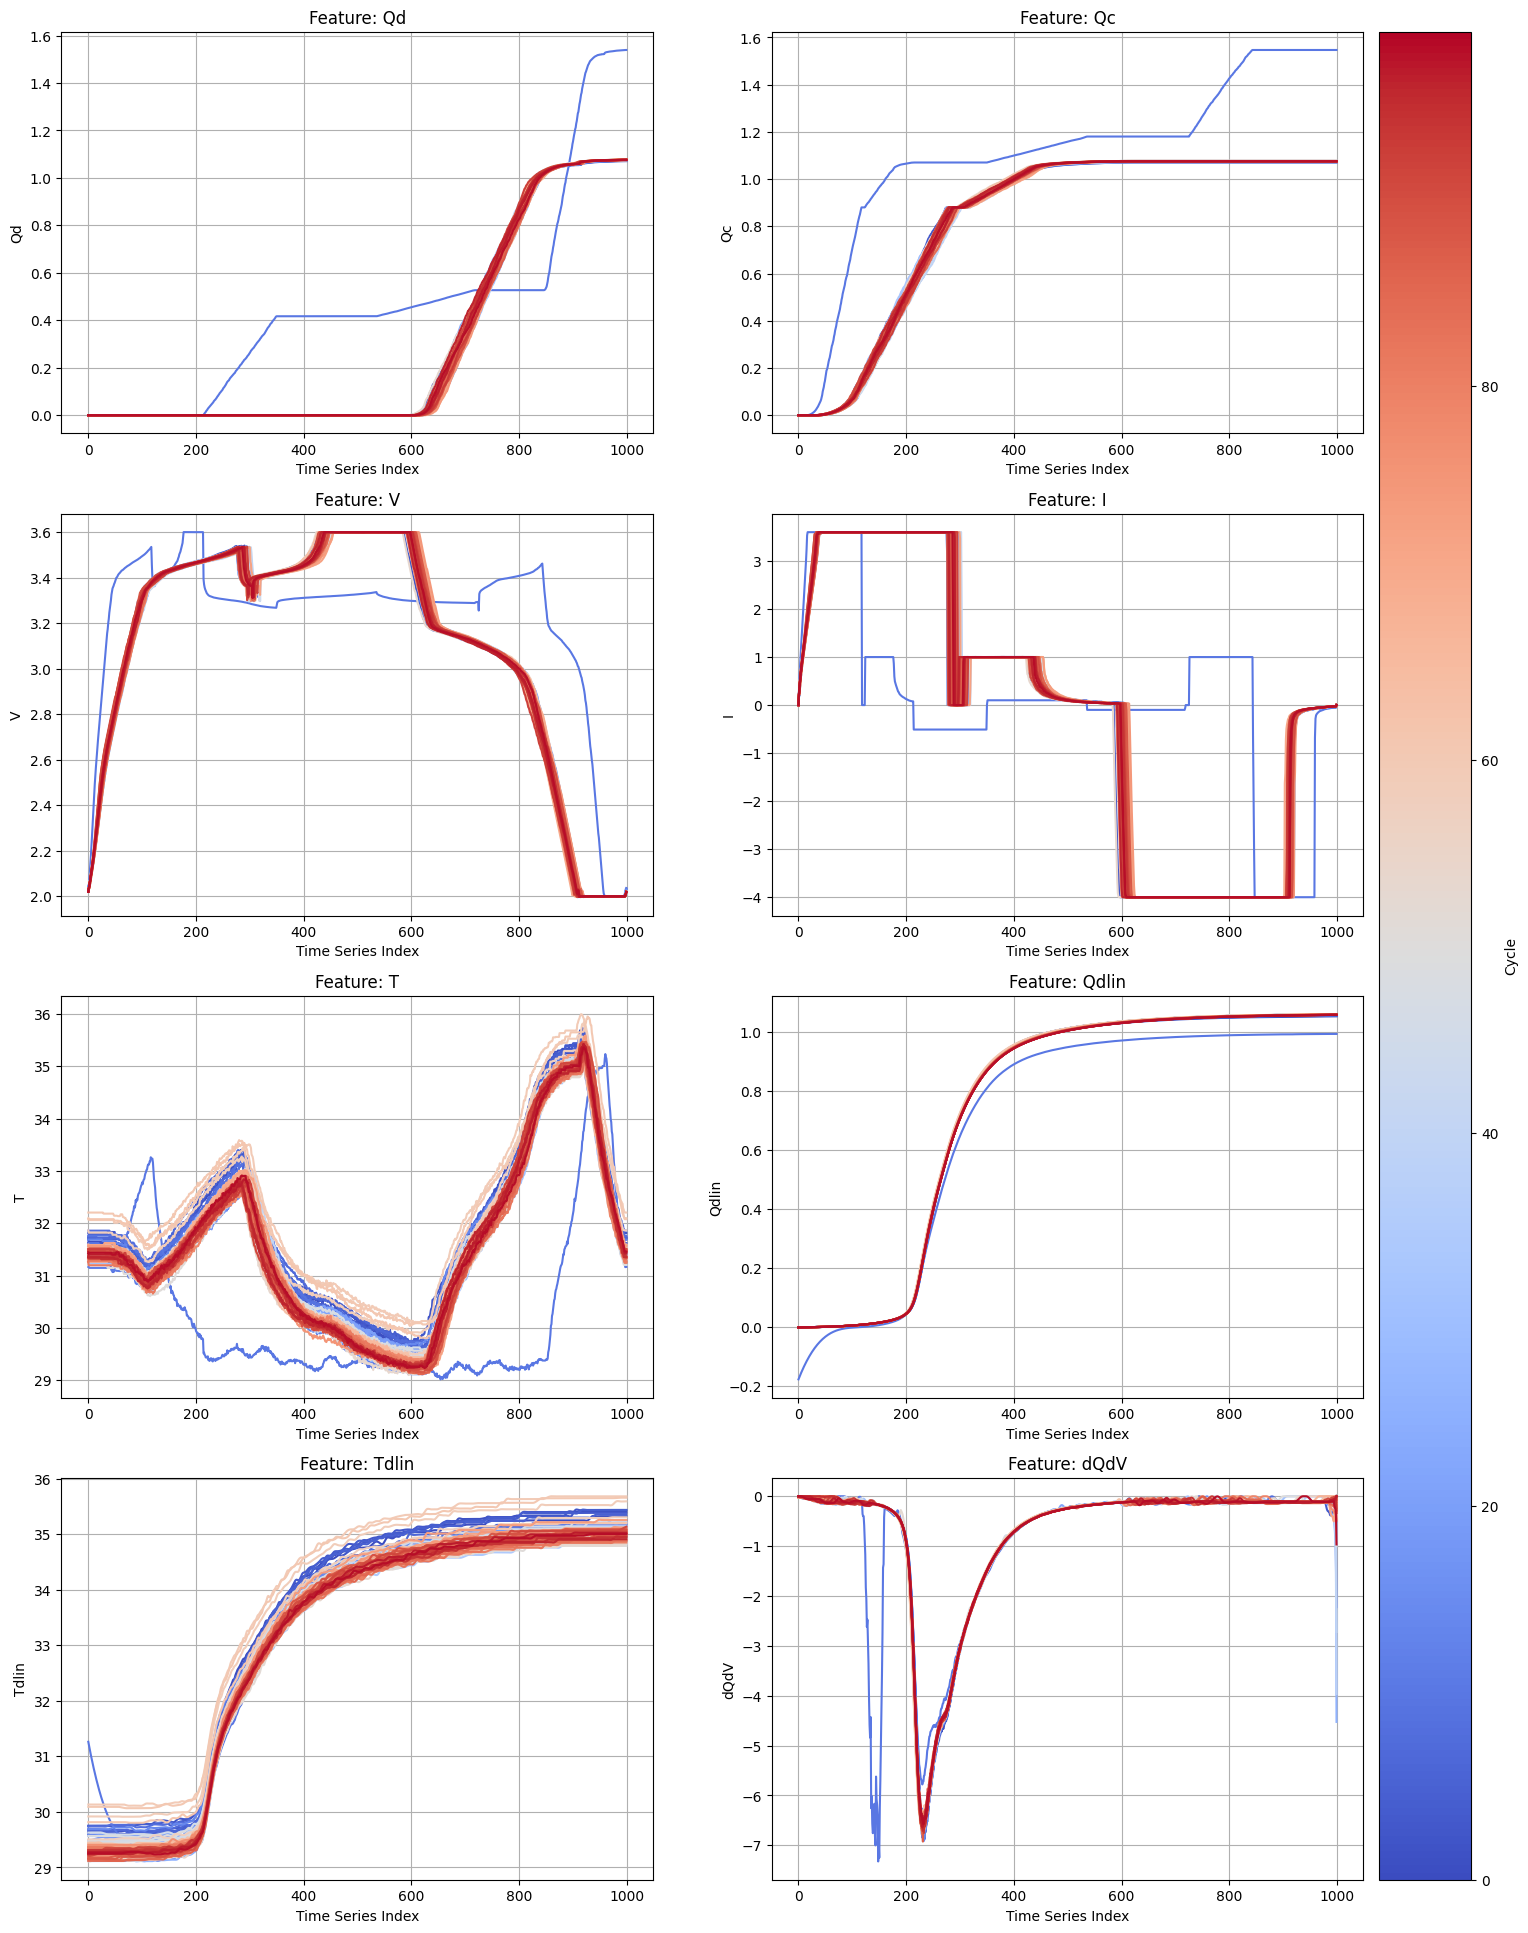

In [ ]:
cl.plot_inp_cycles(cleaned_cycle_data, cell_idx=0)


This function is used in my paper to make statistical data from current and temperature. </br>
Abnormal cells are detected </br>
Abnormal cycles are removed </br>
With parameter changes, user will have different cleansed dataset.
</br>
ch_current_threshold=0.01 </br>
validation_range=20,  </br>
max_gap=20, </br>
max_time=100 </br>

In [ ]:
no_of_features = 5
no_of_cycles = 100
max_data_size = 1000
no_of_timeseries = 500
cycle_start = 1

eol, cycle_data_dis, cycle_data_ch = cl.get_cleaned_cycles(bat_dict, cycle_start, no_of_cycles, max_data_size, no_of_timeseries)


remove cycle 11 from time for cell b1c0
remove cycle 11 from time for cell b1c1
remove cycle 11 from time for cell b1c2
remove cycle 11 from time for cell b1c3
remove cycle 11 from time for cell b1c4
remove cycle 12 from time for cell b1c5
remove cycle 12 from time for cell b1c6
remove cycle 12 from time for cell b1c7
remove cycle 11 from time for cell b1c11
remove cycle 12 from time for cell b1c14
remove cycle 12 from time for cell b1c15
remove cycle 12 from time for cell b1c16
remove cycle 1 from time for cell b1c18
remove cycle 2 from time for cell b1c18
remove cycle 3 from time for cell b1c18
remove cycle 4 from time for cell b1c18
remove cycle 5 from time for cell b1c18
remove cycle 6 from time for cell b1c18
remove cycle 7 from time for cell b1c18
remove cycle 8 from time for cell b1c18
remove cycle 9 from time for cell b1c18
remove cycle 10 from time for cell b1c18
remove cycle 11 from time for cell b1c18
remove cycle 12 from time for cell b1c18
remove cycle 13 from time for cel

Reaming the abnormal cells to see DNN performance and fair comparison. However, It is not practical.

In [ ]:
print(eol.shape, cycle_data_dis.shape, cycle_data_ch.shape)

(124, 1) (124, 100, 5, 500) (124, 100, 5, 500)


In [ ]:
np.save(eol_path',eol)
np.save(cycle_data_dis_path,cycle_data_dis)
np.save(cycle_data_ch_path,cycle_data_ch)

## generation of statistical features

In [ ]:
cycle_sum = cl.getdata_from_summary(bat_dict, 1, 100)

In [ ]:
# convert list to array
cycle_sum=np.array(cycle_sum).reshape(-1,7,100) #(number of cell, features, first n cycle)

In [ ]:
cycle_sum.shape

(124, 7, 100)

In [ ]:
# Extract EOLs from the battery dictionary
EOL = [(key, int(value['cycle_life'][0][0])) for key, value in bat_dict.items()]
battery_ids = [entry[0] for entry in EOL]
EOL_values = [entry[1] for entry in EOL]

In [ ]:
human_data = cl.get_human_data(bat_dict, 1, 100)

In [ ]:
human_data = np.array(human_data)

In [ ]:
human_data.shape

(37200, 1000)

In [ ]:
human_data=np.array(human_data).reshape(124,100,3,1000) #(number of cell, first n cycle, features, time-series data)

In [ ]:
human_data.shape

(124, 100, 3, 1000)

In [ ]:
new_cycle_sum = cl.gen_statistical_data(cycle_sum, human_data, cycle_data_ch, cycle_data_dis)

In [ ]:
new_cycle_sum.shape

(124, 14, 100)

In [ ]:
np.save(new_cycle_sum_path,new_cycle_sum)